In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats
import warnings
from shapely.geometry import Point,Polygon
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import geopandas as gpd
from sklearn.preprocessing import PolynomialFeatures
import descartes
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
import contextily as ctx
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
training_data = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/kc_house_data_train.csv')
bedroomsfilled = pd.read_csv('/Users/brendanferris/Desktop/kings_county_housing/EDA/bedroomsfilled.csv')
census_data = pd.read_excel('/Users/brendanferris/Desktop/kings_county_housing/EDA/extradata.xlsx')
training_data.drop('Unnamed: 0', axis=1, inplace=True)
bedroomsfilled.drop('Unnamed: 0', axis=1, inplace=True)
#census_data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
training_data.shape, bedroomsfilled.shape, census_data.shape

((17290, 21), (12, 21), (70, 15))

# Baseline Model

In [4]:
y = training_data.price
x = training_data.drop(['price', 'date'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=.2)
x_train.shape, x_test.shape

baseline_lr = LinearRegression()
baseline_lr.fit(x_train, y_train)
y_hat = baseline_lr.predict(x_test)
MSE = mean_squared_error(y_test, y_hat)
print('Baseline RMSE:',np.sqrt(MSE).round(5))

Baseline RMSE: 198822.52762


In [5]:
len_ten_percent = int(len(training_data)*.10)
average_top_prices = np.mean(training_data.price.sort_values(ascending=False)[:len_ten_percent])
average_lower_prices = np.mean(training_data.price.sort_values()[:len_ten_percent])

print("The highest 10% of houses are priced above ${}, while the lowest 10% are priced below ${}".format(int(average_top_prices), int(average_lower_prices)))

The highest 10% of houses are priced above $1350116, while the lowest 10% are priced below $203451


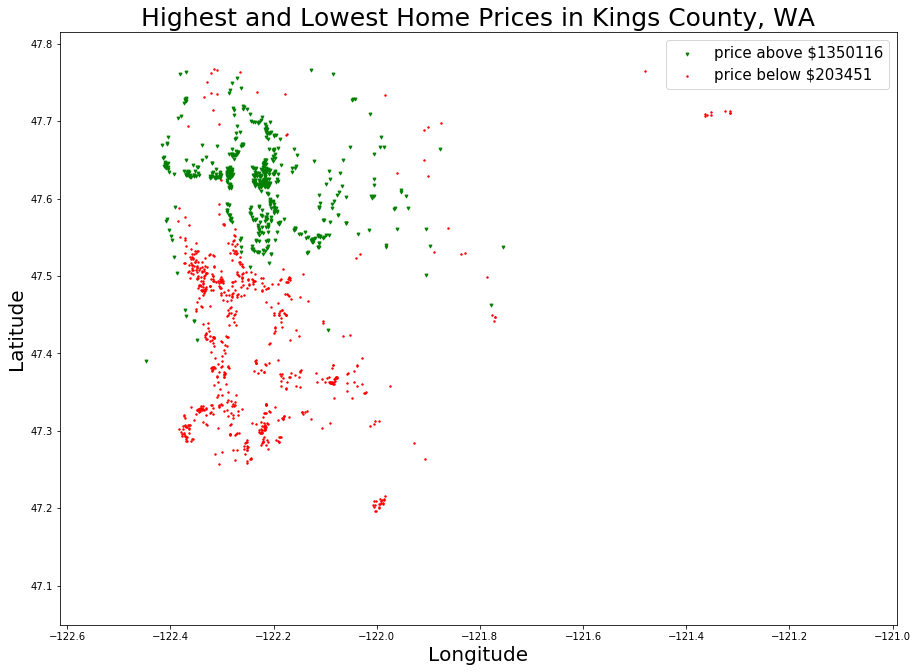

In [6]:
king_map = gpd.read_file('/Users/brendanferris/Desktop/kings_county_housing/EDA/Cities_and_Unincorporated_King_County___city_kc_area-shp')
geometry = [Point(x,y) for x,y in zip(training_data['long'], training_data['lat'])]
fig, ax = plt.subplots(figsize = (15,15))
king_map.plot(ax=ax, alpha = 0.8, color = 'white', aspect='auto')
geo_df = gpd.GeoDataFrame(training_data,  
                          geometry = geometry)

geo_df[geo_df['price'] > average_top_prices].plot(ax = ax , markersize = 8,
                                                  color = 'green', marker = 'v',
                                                  aspect = 1.5, label="price above ${}".format(int(average_top_prices)))
geo_df[geo_df['price'] < average_lower_prices].plot(ax = ax , markersize = 8,
                                                    color = 'red',marker = '.',
                                                    aspect = 1.5, label = "price below ${}".format(int(average_lower_prices)))

ax.set_title('Highest and Lowest Home Prices in Kings County, WA', fontdict =
             {'fontsize': 25})

ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})
plt.legend(prop={"size":15});

#remove geometry no longer needed
training_data.drop(['geometry'], axis=1, inplace=True)

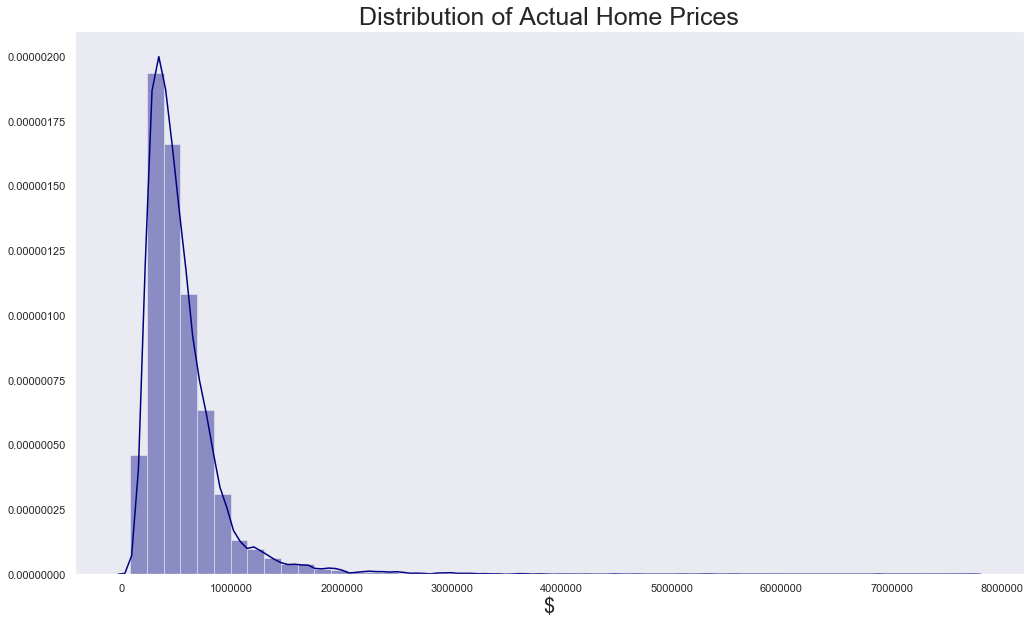

In [38]:
sns.set(rc={'figure.figsize':(17,10)})
sns.set_style('dark')
sns.distplot(training_data['price'], color='navy')

plt.xlabel("$", fontsize= 20)
plt.title("Distribution of Actual Home Prices", fontsize= 25);

# Fill in missing values.

In [8]:
correct_baths = bedroomsfilled.bathrooms.to_list()
correct_beds = bedroomsfilled.bedrooms.to_list()
ind = training_data.loc[training_data.bedrooms == 0].index.to_list()

new_col = pd.Series(correct_beds, name='bedrooms', index=ind)
new_col2 = pd.Series(correct_baths, name='bathrooms', index=ind)

training_data.update(new_col)
training_data.update(new_col2)

In [9]:
training_data.shape

(17290, 21)

# Removing Outliers

In [10]:
def clean_beds(dataframe):
    median_beds = dataframe.bedrooms.median()
    dataframe['bedrooms'].values[dataframe['bedrooms'].values > 10] = median_beds
    print('Entries with an abnormal amount of bedrooms have been replaced with {}, the median number of bedrooms in the dataframe. \n'.format(median_beds))

In [11]:
clean_beds(training_data)

Entries with an abnormal amount of bedrooms have been replaced with 3.0, the median number of bedrooms in the dataframe. 



In [12]:
training_data.iloc[[7519, 1979,4217, 3275, 6611, 2654, 14753]]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7519,9208900037,20140919T000000,6885000.0,6.0,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
1979,8907500070,20150413T000000,5350000.0,5.0,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
4217,2303900035,20140611T000000,2888000.0,5.0,6.25,8670,64033,2.0,0,4,...,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021
3275,1225069038,20140505T000000,2280000.0,7.0,8.00,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
6611,2303900100,20140911T000000,3800000.0,3.0,4.25,5510,35000,2.0,0,4,...,13,4910,600,1997,0,98177,47.7296,-122.370,3430,45302
2654,5493110080,20140815T000000,1825000.0,3.0,3.75,6030,39317,2.0,0,0,...,11,4440,1590,1991,0,98004,47.6055,-122.210,4040,12333
14753,8661000089,20140716T000000,199950.0,3.0,2.75,2270,13590,1.5,0,0,...,6,1300,970,1948,0,98022,47.2099,-122.001,1160,13545


 # Adding Features

In [13]:
training_data['home_age'] =  2015 - training_data.yr_built
#training_data['available_housing'] = training_data['total_housing_units'] - training_data['occupied_housing_units']

#turning date into datetime so we can extract sale year/month
training_data['date'] = pd.to_datetime(training_data['date'])

training_data['sale_year'] = pd.DatetimeIndex(training_data['date']).year
training_data['sale_month'] = pd.DatetimeIndex(training_data['date']).month
training_data.drop(columns='date', inplace=True)

##### Dummy Features for categorical variables.

In [14]:
waterfront_dummies = pd.get_dummies(training_data['waterfront'], prefix='waterf', drop_first=True)
view_dummies = pd.get_dummies(training_data['view'], prefix='has_view', drop_first=True)
condition_dummies = pd.get_dummies(training_data['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
month_dummies = pd.get_dummies(training_data['sale_month'], prefix='month', drop_first=True)
zip_dummies = pd.get_dummies(training_data['zipcode'], prefix='zip', drop_first=True)

In [15]:
training_data = training_data.drop(['id','zipcode','sale_month','waterfront', 'view', 'condition', 'grade'], axis=1) #dropped postoffice
training_data = pd.concat([training_data, waterfront_dummies, view_dummies, condition_dummies, grade_dummies, month_dummies, zip_dummies], axis=1)

# Removing Colinear Features

In [16]:
def multicolinear_features(data):
    '''
    input: dataframe
    returns a dataframe of all colinear features in a dataframe.
    '''

    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc']
    return df[(df.cc>.75) & (df.cc <1)]

In [17]:
multicolinear_features(training_data)

,cc
pairs,
"(sqft_living, sqft_above)",0.876696
"(sqft_above, sqft_living)",0.876696
"(condition_3, condition_4)",0.810849
"(condition_4, condition_3)",0.810849
"(bathrooms, sqft_living)",0.756908
"(sqft_living, bathrooms)",0.756908
"(sqft_living, sqft_living15)",0.755066
"(sqft_living15, sqft_living)",0.755066


In [18]:
training_data.drop([
                    'sqft_living', 
                    'condition_3',
                    ], axis=1, inplace=True)

In [19]:
multicolinear_features(training_data) # Should be empty

,cc
pairs,


# Adding polynomial features.

In [21]:
poly_feats = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly_feats.fit_transform(training_data.drop(columns='price', axis=1))
poly_columns = poly_feats.get_feature_names(training_data.columns.drop('price'))
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
df_poly.shape

(17290, 6554)

In [22]:
y = training_data.price

# Train/test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_poly, y, random_state=42,test_size=0.2)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13832, 6554), (3458, 6554), (13832,), (3458,))

# Selecting the best features.

In [25]:
selector = SelectKBest(f_regression, k=250)

selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [26]:
#instantiate
lm_kbest = LinearRegression()

#fit
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 137381.40015660028
Testing Root Mean Squared Error: 166897.24319633335


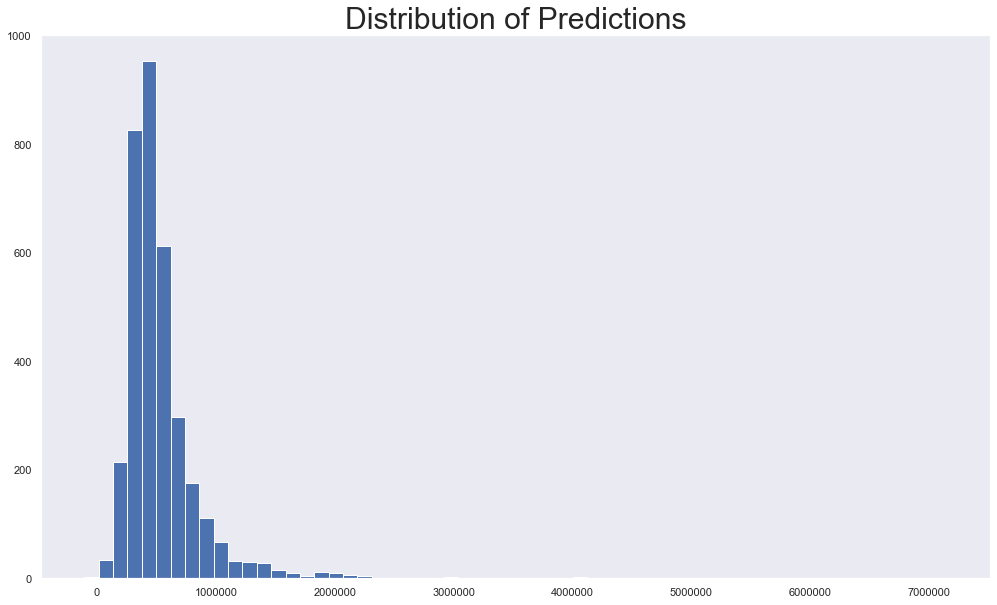

In [27]:
plt.hist(y_kbest, bins=60);
plt.title('Distribution of Predictions', size=30);

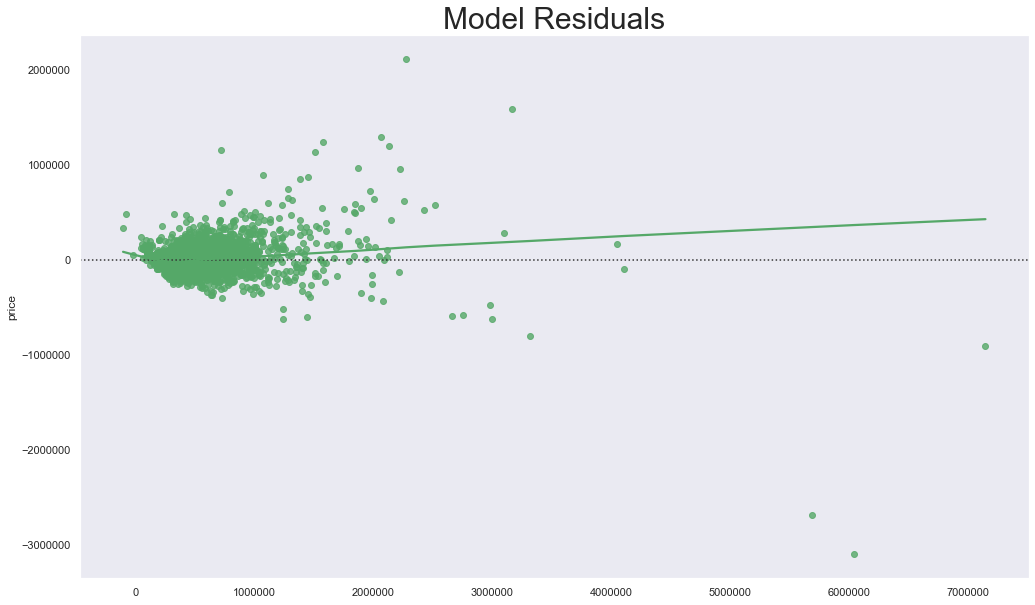

In [28]:
sns.residplot(y_kbest, y_test, lowess=True, color='g');
plt.title('Model Residuals', size=30);

In [33]:
selected_columns.to_list()

['bedrooms',
 'bathrooms',
 'floors',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'waterf_1',
 'has_view_3',
 'has_view_4',
 'grade_6',
 'grade_7',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'zip_98004',
 'zip_98039',
 'zip_98040',
 'bedrooms^2',
 'bedrooms bathrooms',
 'bedrooms floors',
 'bedrooms sqft_above',
 'bedrooms sqft_basement',
 'bedrooms yr_built',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_living15',
 'bedrooms sale_year',
 'bedrooms waterf_1',
 'bedrooms has_view_3',
 'bedrooms has_view_4',
 'bedrooms grade_6',
 'bedrooms grade_7',
 'bedrooms grade_9',
 'bedrooms grade_10',
 'bedrooms grade_11',
 'bedrooms grade_12',
 'bedrooms grade_13',
 'bedrooms zip_98004',
 'bedrooms zip_98039',
 'bedrooms zip_98040',
 'bedrooms zip_98112',
 'bathrooms^2',
 'bathrooms floors',
 'bathrooms sqft_above',
 'bathrooms sqft_basement',
 'bathrooms yr_built',
 'bathrooms yr_renovated',
 'bathrooms lat',
 'bathrooms long',
 'bathrooms sqft_living1

# Final Model

In [34]:
lm_final = lm_kbest.fit(df_poly[selected_columns], training_data.price)

In [35]:
import pickle


pickle_out = open("final_model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()